In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn

from model import Net
from training import NumpyDataset

import matplotlib.pyplot as plt

In [2]:
# Paths to the model and data
model_path = "/home/arthur/Desktop/Code/warmstart-mpc/example/models/trained_model_box_6000.pth"

# Load data from .npy file
data = np.load(
    "/home/arthur/Desktop/Code/warmstart-mpc/example/results/results_box_6000.npy",
    allow_pickle=True,
)
T = len(data[0, 2])
nq = len(data[0, 0])
net = Net(nq, T)


In [3]:
# Load the model state
if os.path.exists(model_path):
    net.load_state_dict(torch.load(model_path))
    print("Model loaded successfully.")
else:
    print("Model file does not exist.")
    exit()


Model loaded successfully.


In [4]:
# Create dataset and dataloader
dataset = NumpyDataset(data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [8]:
data[53][2]

array([[-1.0804473 , -1.12987052,  0.23887809, -1.35014567,  1.0326046 ,
         1.47554925,  2.12593491],
       [-0.96001442, -1.03420336,  0.25778731, -1.3511036 ,  0.90890291,
         1.55097967,  2.01803953],
       [-0.83958154, -0.93853619,  0.27669653, -1.35206153,  0.78520122,
         1.62641009,  1.91014414],
       [-0.71914865, -0.84286903,  0.29560574, -1.35301946,  0.66149952,
         1.70184051,  1.80224876],
       [-0.59871577, -0.74720186,  0.31451496, -1.35397738,  0.53779783,
         1.77727093,  1.69435337],
       [-0.47828289, -0.6515347 ,  0.33342418, -1.35493531,  0.41409613,
         1.85270134,  1.58645799],
       [-0.35785   , -0.55586753,  0.3523334 , -1.35589324,  0.29039444,
         1.92813176,  1.4785626 ],
       [-0.23741712, -0.46020037,  0.37124262, -1.35685116,  0.16669274,
         2.00356218,  1.37066722],
       [-0.11698424, -0.3645332 ,  0.39015183, -1.35780909,  0.04299105,
         2.0789926 ,  1.26277183],
       [ 0.00344864, -0.2688

In [5]:
# Set the model to evaluation mode
net.eval()


Net(
  (fc1): Linear(in_features=14, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=140, bias=True)
)

Diff is the squared difference between the prediction and the actual value

In [6]:
# Initialize lists to store predictions and actual values
predictions = []
actuals = []
diff = []

# Make predictions and compare with actual values
with torch.no_grad():
    for inputs, actual in dataloader:
        output = net(inputs)
        diff.append((output.numpy()[0] - actual.numpy()[0])**2)
        predictions.append(output)
        actuals.append(actual)

In [7]:
mean_diff = np.mean(diff, axis=0)
std_diff = np.std(diff, axis=0)

In [8]:
std_diff[0]

array([0.00069881, 0.00075449, 0.00051683, 0.00052852, 0.00100354,
       0.00051993, 0.00077209], dtype=float32)

In [9]:
mean_diff[0]

array([0.00041042, 0.00060154, 0.00024634, 0.00048859, 0.00105598,
       0.00028856, 0.00073213], dtype=float32)

Let's plot the difference of a given sample :

In [10]:
from collections import defaultdict 

q = defaultdict(list)
q_sup_std = defaultdict(list)
q_inf_std = defaultdict(list)
for config_t, std_config_t in zip(mean_diff, std_diff):
    for i, (q_i, std_q_i) in enumerate(zip(config_t, std_config_t)):
        q[f"q_{i}"].append(q_i)
        q_sup_std[f"q_{i}"].append(q_i + std_q_i)
        q_inf_std[f"q_{i}"].append(q_i - std_q_i)


In [11]:
len(q_sup_std["q_1"])

20

Plotting the result

[-0.0002883931, -0.00066340936, -0.0021107541, -0.004562102, -0.008214614, -0.012683669, -0.017880773, -0.024104783, -0.031119978, -0.039519668, -0.048691522, -0.05827139, -0.06855305, -0.07190916, -0.07222877, -0.07197433, -0.07011377, -0.06830791, -0.06731568, -0.06613352]
[-0.00015295576, -0.0002072131, -0.0010300449, -0.0024293102, -0.0043578227, -0.006805359, -0.009706982, -0.013290404, -0.017353244, -0.021832049, -0.027090892, -0.032240838, -0.03803333, -0.03473302, -0.029206343, -0.024665693, -0.020118572, -0.016795611, -0.0141669195, -0.01253979]
[-0.0002704916, -0.001930533, -0.007516151, -0.017005367, -0.030211931, -0.047023103, -0.06691684, -0.09139624, -0.11924272, -0.15083355, -0.18614143, -0.22125724, -0.24625407, -0.24827267, -0.24541108, -0.24125068, -0.23692214, -0.23210157, -0.22879452, -0.22628845]
[-3.993197e-05, -1.8581632e-05, -0.00084981986, -0.0022984967, -0.0045614084, -0.008283209, -0.012206752, -0.017033726, -0.022382557, -0.027213724, -0.03540909, -0.0414208

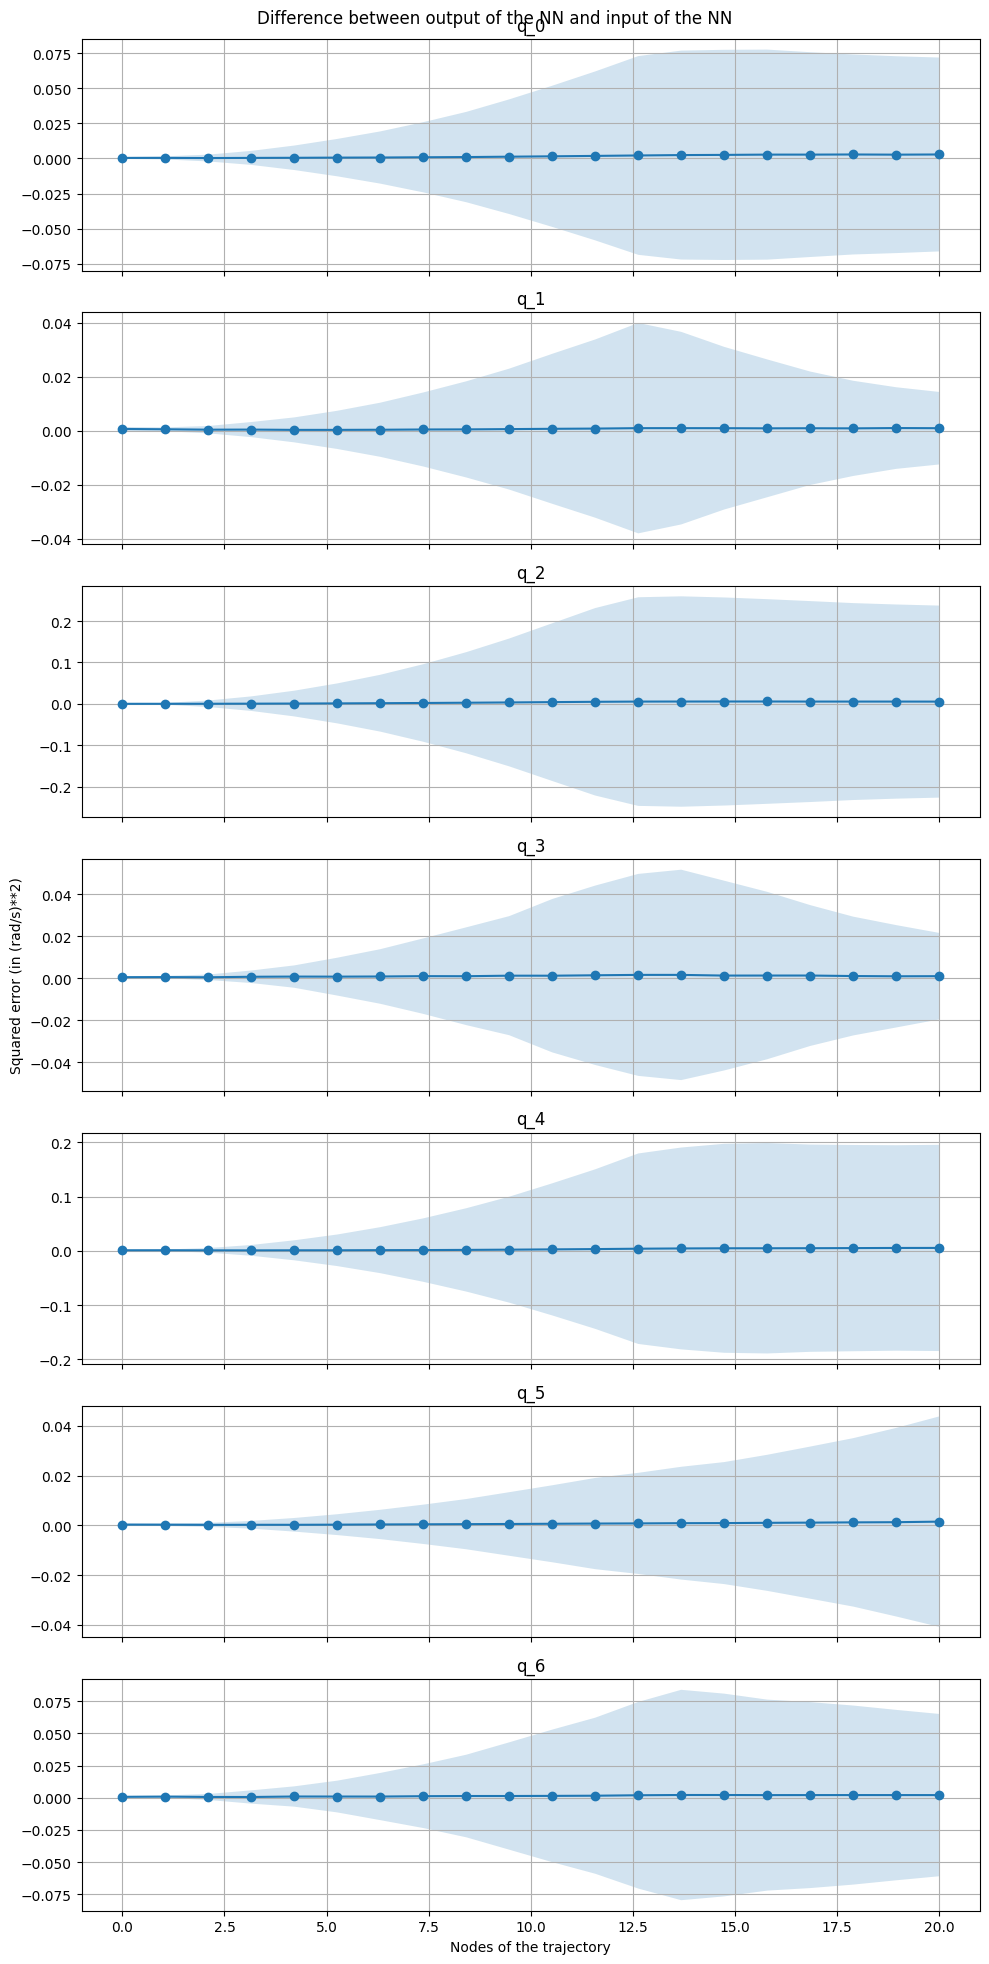

In [12]:
fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=True)
nodes = np.linspace(0,len(q["q_0"]), len(q["q_0"]))
for i, (((key, q_i),q_i_inf), q_i_sup) in enumerate(zip(zip(q.items(), q_inf_std.values()), q_sup_std.values())):
    print(q_i_inf)
    axes[i].plot(nodes,q_i, "-o")
    axes[i].fill_between(nodes, q_i_inf, q_i_sup, alpha=0.2, label=f'{key} ± std')
    axes[i].set_title(key)
    axes[i].set_title(key)

    axes[i].grid("on")
axes[3].set_ylabel("Squared error (in (rad/s)**2)")
axes[-1].set_xlabel("Nodes of the trajectory")
plt.suptitle("Difference between output of the NN and input of the NN")
plt.tight_layout()
# plt.show()

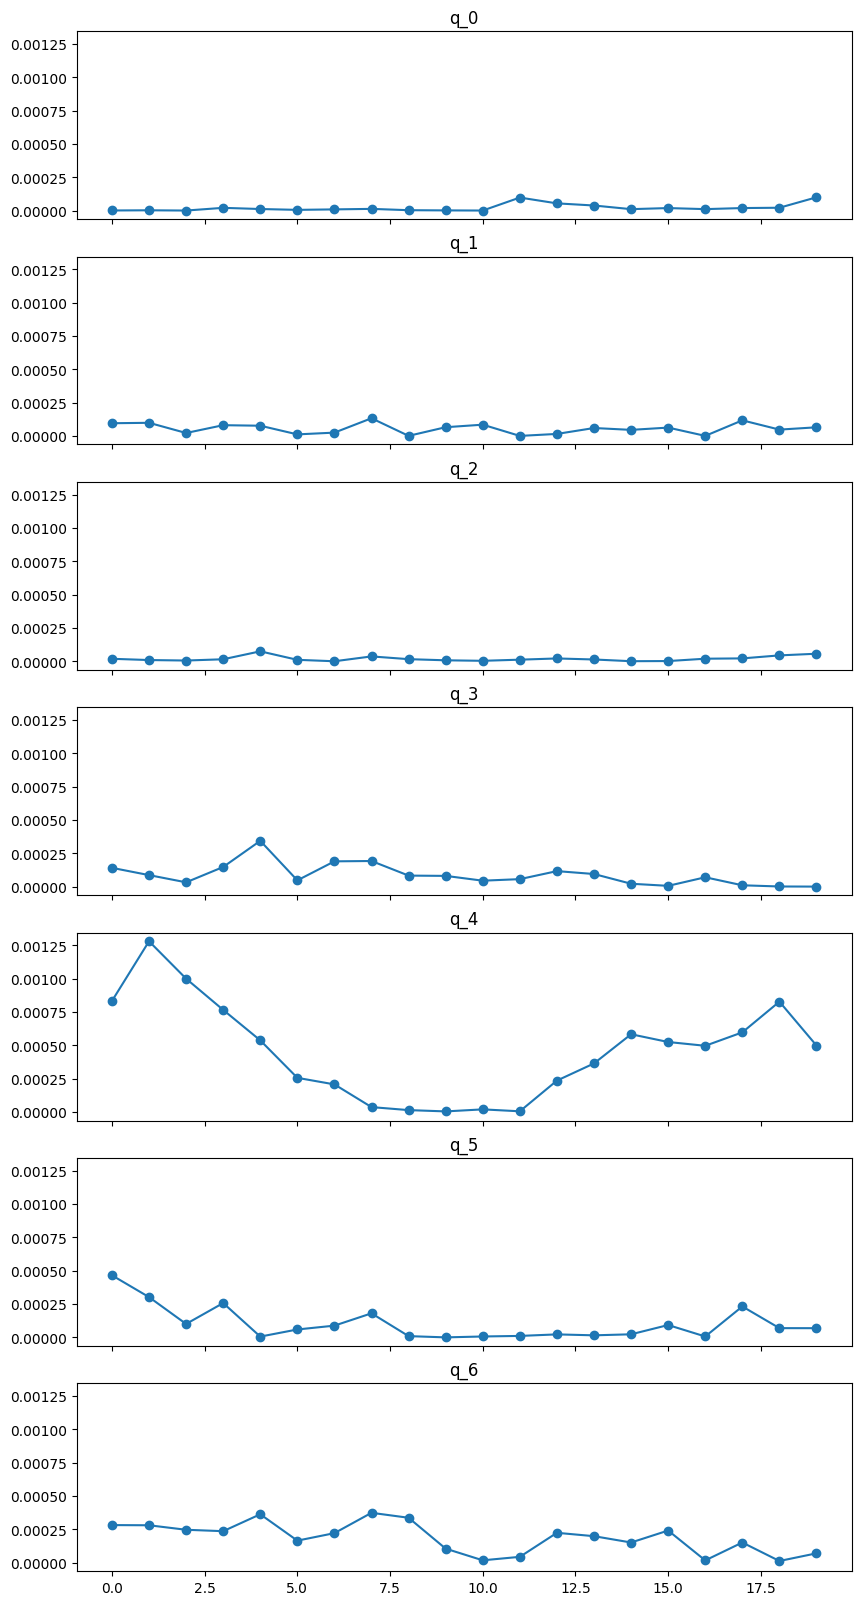

In [13]:
diff_60 = diff[80]
q = defaultdict(list)
for config_t in diff_60:
    for i, q_i in enumerate(config_t):
        q[f"q_{i}"].append(q_i)
fig, axes = plt.subplots(7, 1, figsize=(10, 20), sharex=True, sharey=True)
for i, (key, q_i) in enumerate(q.items()):
    axes[i].plot(q_i, "-o")
    axes[i].set_title(key)